In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
import open_clip
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
class MisogynyDataset(Dataset):
    def __init__(self, data, label_map, transform=None):
        self.data = data.reset_index(drop=True)
        self.label_map = label_map
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        image = self.transform(image)
        label = self.label_map[row["image_label"]]
        caption = row["image_caption"]
        return image, caption, label

class MisogynyDataLoader:
    def __init__(self, csv_file="data_csv.csv", batch_size=16, test_size=0.2, random_state=42,
                 train_transform=None, test_transform=None, num_workers=0, pin_memory=False):
        data = pd.read_csv(csv_file)
        label_map = {"kitchen":0, "shopping":1, "working":2, "leadership":3}

        train_df, test_df = train_test_split(
            data,
            test_size=test_size,
            random_state=random_state,
            shuffle=True,
            stratify=data["image_label"]
        )

        self.train_dataset = MisogynyDataset(train_df, label_map, transform=train_transform)
        self.test_dataset = MisogynyDataset(test_df, label_map, transform=test_transform)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=num_workers, pin_memory=pin_memory)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=num_workers, pin_memory=pin_memory)


In [4]:
class BERTEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.model_bert = BertModel.from_pretrained("bert-base-uncased")
        self.model_bert.eval()

    def forward(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model_bert(**inputs)
        token_embeddings = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"]
        mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sentence_embeddings = (token_embeddings * mask).sum(dim=1) / mask.sum(dim=1)
        embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return embeddings

class OpenClipVitEmbedder(nn.Module):
    def __init__(self, device=None):
        super().__init__()
        self.model, _, self.preprocess = open_clip.create_model_and_transforms(
            model_name="ViT-B-32", pretrained="openai"
        )
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, image_tensor):
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image_tensor)
        image_features = F.normalize(image_features, p=2, dim=-1)
        return image_features


In [5]:
def collect_embeddings(dataloader, text_model, image_model, device):
    text_embeddings = []
    image_embeddings = []

    for images, captions, _ in dataloader:
        captions = list(captions)
        with torch.no_grad():
            text_emb = text_model(captions).to("cpu")
            image_emb = image_model(images).to("cpu")
        text_embeddings.append(text_emb.numpy())
        image_embeddings.append(image_emb.numpy())

    text_embeddings = np.vstack(text_embeddings)
    image_embeddings = np.vstack(image_embeddings)
    return text_embeddings, image_embeddings

In [6]:
class LDALayer(nn.Module):
    def __init__(self, mean, coef):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32))
        self.register_buffer("weight", torch.tensor(coef, dtype=torch.float32))  # coef_: (C-1, D)

    def forward(self, x):
        x = x - self.mean
        x = torch.matmul(x, self.weight.T)
        return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataloaders = MisogynyDataLoader()
train_loader = dataloaders.train_loader

text_model = BERTEmbedder().to(device)
image_model = OpenClipVitEmbedder(device=device)

text_train_emb, image_train_emb = collect_embeddings(train_loader, text_model, image_model, device)
labels = np.array([label for _, _, label in dataloaders.train_dataset])
num_classes = len(np.unique(labels))

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2237.01it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/Users/vishnurchityala/FILES/USERS/VISHNU/PROJECTS/ONGOING-PROJECTS/graph-networks/venv/lib/python3.12/site-packages/open_clip/factory

In [15]:
len(text_train_emb[0])

768

In [8]:
lda_text = LinearDiscriminantAnalysis(n_components=num_classes-1)
text_lda = lda_text.fit_transform(text_train_emb, labels)

lda_image = LinearDiscriminantAnalysis(n_components=num_classes-1)
image_lda = lda_image.fit_transform(image_train_emb, labels)

lda_combined = LinearDiscriminantAnalysis(n_components=num_classes-1)
combined_emb = np.concatenate([text_train_emb, image_train_emb], axis=1)
combined_lda = lda_combined.fit_transform(combined_emb, labels)

In [9]:
text_lda_layer = LDALayer(lda_text.xbar_, lda_text.coef_)
image_lda_layer = LDALayer(lda_image.xbar_, lda_image.coef_)
combined_lda_layer = LDALayer(lda_combined.xbar_, lda_combined.coef_)

In [10]:
text_emb_tensor = torch.tensor(text_train_emb, dtype=torch.float32)
text_emb_lda = text_lda_layer(text_emb_tensor) 
print("Text LDA shape:", text_emb_lda.shape)

Text LDA shape: torch.Size([1704, 4])


In [17]:
text_emb_lda[0]

tensor([ 0.0709,  2.2492, -2.1841,  0.3393])

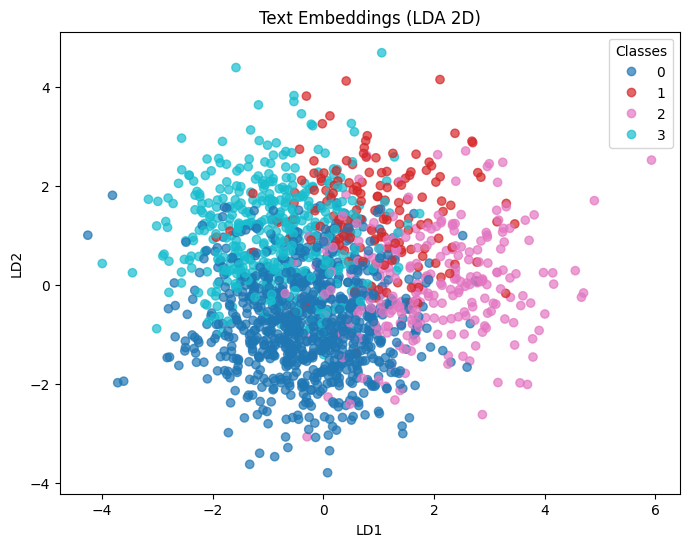

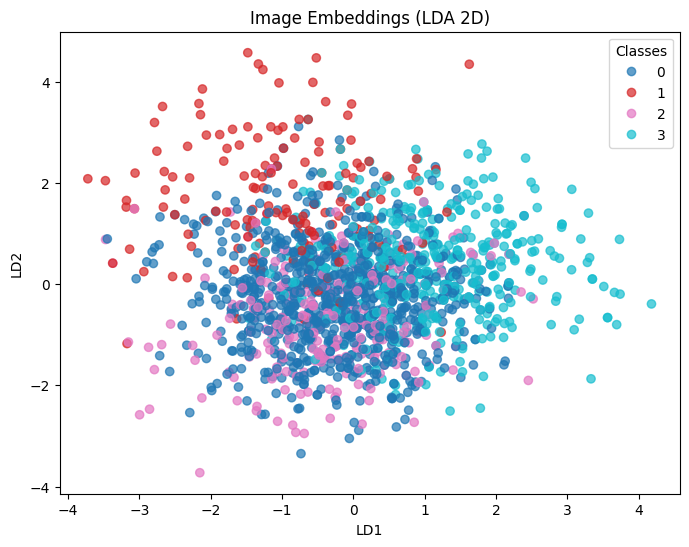

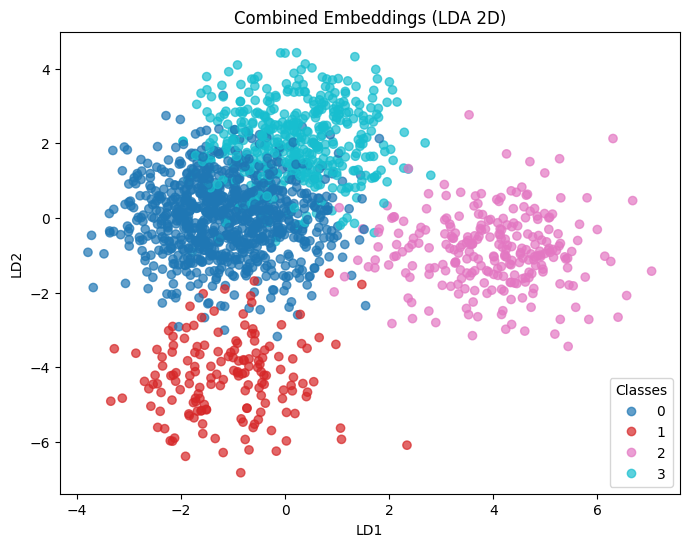

In [11]:
def plot_2d(emb_2d, labels, title="2D LDA"):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("LD1")
    plt.ylabel("LD2")
    plt.show()

plot_2d(text_lda[:, :2], labels, title="Text Embeddings (LDA 2D)")
plot_2d(image_lda[:, :2], labels, title="Image Embeddings (LDA 2D)")
plot_2d(combined_lda[:, :2], labels, title="Combined Embeddings (LDA 2D)")

In [ ]:
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(text_lda)

ari = adjusted_rand_score(labels, cluster_labels)
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"K-Means on LDA (Text) ARI: {ari:.4f}")
print(f"K-Means on LDA (Text) NMI: {nmi:.4f}")

K-Means on LDA (Text) ARI: 0.4132
K-Means on LDA (Text) NMI: 0.4023


In [ ]:
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(image_lda)

ari = adjusted_rand_score(labels, cluster_labels)
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"K-Means on LDA (Image) ARI: {ari:.4f}")
print(f"K-Means on LDA (Image) NMI: {nmi:.4f}")

K-Means on LDA (Image) ARI: 0.2158
K-Means on LDA (Image) NMI: 0.2329


In [ ]:
kmeans = KMeans(n_clusters=num_classes, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(combined_lda)

ari = adjusted_rand_score(labels, cluster_labels)
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"K-Means on LDA (Combined) ARI: {ari:.4f}")
print(f"K-Means on LDA (Combined) NMI: {nmi:.4f}")

K-Means on LDA (Combined) ARI: 0.9269
K-Means on LDA (Combined) NMI: 0.8991


In [26]:
combined_lda_clean = normalize(combined_lda, axis=1)
k = 20
affinity_matrix = kneighbors_graph(combined_lda_clean, n_neighbors=k, mode='connectivity', include_self=True)
affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)

sc = SpectralClustering(n_clusters=num_classes, affinity='precomputed', random_state=42)
graph_labels = sc.fit_predict(affinity_matrix)

ari_graph = adjusted_rand_score(labels, graph_labels)
nmi_graph = normalized_mutual_info_score(labels, graph_labels)
print(f"Spectral Clustering on LDA Graph (k-NN) ARI: {ari_graph:.4f}")
print(f"Spectral Clustering on LDA Graph (k-NN) NMI: {nmi_graph:.4f}")

Spectral Clustering on LDA Graph (k-NN) ARI: 0.7860
Spectral Clustering on LDA Graph (k-NN) NMI: 0.7654


In [ ]:
np.save("combined_lda_mean.npy", lda_combined.xbar_)
np.save("combined_lda_coef.npy", lda_combined.coef_)

print("Combined LDA weights saved successfully!")

Combined LDA weights saved successfully!
